<a href="https://colab.research.google.com/github/preetamjumech/LLM/blob/main/LangGraph_12_11_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://ollama.ai/install.sh | sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13320    0 13320    0     0  29835      0 --:--:-- --:--:-- --:--:-- 29865
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [2]:
!echo 'debconf debconf/frontend select Noninteractive' | sudo debconf-set-selections

In [3]:
!nohup ollama serve &

nohup: appending output to 'nohup.out'


In [4]:
!ollama pull llama3.2:1b

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠴ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠸ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠦ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest 
pulling 74701a8c35f6...   0% ▕▏    0 B/1.3 GB                  pulling manifest 
pulling 74701a8c35f6...   0% ▕▏    0 B/1.3 GB                  pulling manifest 
pulling 74701a8c35f6...   0% ▕▏    0 B/1.3 GB                  pulling manifest 
pulling 74701a8c35f6...   0% ▕▏    0 B/1.3 GB                  pulling manifest 
pulling 74701a8c35f6...   0% ▕▏    0 B/1.3 GB                  pulling manifest 
pulling 74701a8c35f6...   0% ▕▏    0 B/1.3 GB                  pulling manifest 
pulling 74701a8c35f6...   0% ▕▏    0 B/1.3 GB                  pulling manifest 
pulling 74701a8c

In [5]:
%%capture
%pip install -U langgraph langsmith

# Used for this tutorial; not a requirement for LangGraph
%pip install -U langchain-openai

In [6]:
from langgraph.graph import Graph

# define a langchain graph
graph_builder = Graph()

In [7]:
# lets first understand how the Graph things work here
# nodes act like functions that can be called as needed
def function_1(input_1):
    return input_1 + " Hi "

def function_2(input_2):
    return input_2 + "there"

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever the node is used.
graph_builder.add_node("node_1", function_1)
graph_builder.add_node("node_2", function_2)

In [8]:
graph_builder.add_edge("node_1", "node_2")
graph_builder.set_entry_point("node_1")
graph_builder.set_finish_point("node_2")

In [9]:
graph = graph_builder.compile()

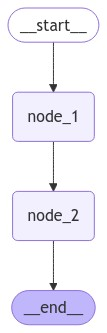

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
# now, lets run the chatbot
graph.invoke("Hello")

'Hello Hi there'

In [14]:
# langsmith makes it esier to see what's going on "under the hood"
# https://eu.smith.langchain.com
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [13]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langgraph demo"

LANGCHAIN_API_KEY: ··········


In [3]:
from langchain_openai import ChatOpenAI

In [4]:
llm_local = ChatOpenAI(api_key="provide_aynthing_here",model="llama3.2:1b",base_url="http://localhost:11434/v1",)

In [5]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [6]:
def chatbot(state: State):
    return {"messages": [llm_local.invoke(state["messages"])]}

# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [7]:
# Next, add an entry point. This tells our graph where to start its work each time we run it.
graph_builder.add_edge(START, "chatbot")

In [8]:
# Similarly, set a finish point. This instructs the graph "any time this node is run, you can exit."
graph_builder.add_edge("chatbot", END)

In [9]:
# Finally, we'll want to be able to run our graph. To do so, call "compile()" on the graph builder.
# This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

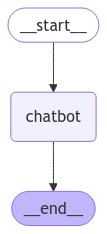

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
# now, lets run the chatbot
# Tip: You can exit the chat loop at any time by typing "quit", "exit", or "q".

while True:  # Start an infinite loop to keep the program running until a break condition is met.
    user_input = input("User: ")  # Prompt the user to input a message.

    # Check if the user wants to quit by typing "quit", "exit", or "q" (case-insensitive).
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # Print a goodbye message.
        break  # Exit the loop and end the program.

    # Stream events from the 'graph' using the user input, processing each event returned.
    for event in graph.stream({"messages": ("user", user_input)}):
        # Iterate over each value in the event.
        for value in event.values():
            # Print the assistant's response, which is the last message in the 'messages' list of the value.
            print("Assistant:", value["messages"][-1].content)

User: hi
Assistant: How are you doing today? Is there something I can help you with or would you like to chat?
User: what is the current temperature of bengaluru?
Assistant: I'm not aware of your current location or any information about the current weather conditions in Bengaluru. However, I can suggest some ways for you to find out the current temperature in Bengaluru.

You can check online weather websites such as AccuWeather, Weather.com, or the India Meteorological Department (IMD) website for the current temperature in Bengaluru. You can also download mobile apps like Dark Sky, Weather Underground, or The Weather Channel to get real-time weather updates, including temperature.

Additionally, you can check the news websites of local newspapers such as The Hindu, Times of India, or Bangalore Mirror to find out about any current weather-related news and updates in Bengaluru.
User: q
Goodbye!


In [11]:
llm_local.invoke("hello world!")

AIMessage(content="Hello World is a classic programming statement that is used to demonstrate the basics of a program. It's often used as a starting point for more complex projects.\n\nWhat would you like to talk about? Want to build something from scratch, or do you have a specific problem or question in mind? I'm here to help!", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 28, 'total_tokens': 93, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'llama3.2:1b', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'stop', 'logprobs': None}, id='run-29e02557-d342-4e97-9177-5574793f117f-0', usage_metadata={'input_tokens': 28, 'output_tokens': 65, 'total_tokens': 93, 'input_token_details': {}, 'output_token_details': {}})

In [12]:
%%capture
%pip install -U tavily-python
%pip install -U langchain_community

In [15]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


In [16]:
# lets define the tool

from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]

In [17]:
tool.invoke("What is the current temperature of Bengaluru in Celsius?")

[{'url': 'https://www.timeanddate.com/weather/india/bangalore/ext',
  'content': 'Bengaluru 14 Day Extended Forecast. Weather Today Weather Hourly 14 Day Forecast Yesterday/Past Weather Climate (Averages) Currently: 81 °F. Passing clouds. (Weather station: Bangalore / Hindustan, India). See more current weather.'},
 {'url': 'https://www.accuweather.com/en/in/bengaluru/204108/current-weather/204108',
  'content': 'Current weather in Bengaluru, Karnataka, India. Check current conditions in Bengaluru, Karnataka, India with radar, hourly, and more.'}]

In [26]:
llm_with_tools = llm_local.bind_tools(tools)

In [27]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

#llm = ChatOpenAI(temperature=0, streaming=True)
#llm = ChatAnthropic(model="claude-3-haiku-20240307")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm_local.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [28]:
import json
from langchain_core.messages import ToolMessage
from typing import Dict

class BasicToolNode:
    """A class representing a node that processes and executes tool requests embedded in the last AI message."""

    def __init__(self, tools: list) -> None:
        """
        Initializes the BasicToolNode with a list of available tools.
        Args:
            tools (list): A list of tool objects that the node can use to execute requests.
        """
        # Creates a dictionary mapping tool names to tool objects for quick lookup during execution
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """
        Processes the input data to extract the latest message and execute the requested tools.
        Args:
            inputs (dict): A dictionary containing messages, where each message can contain tool calls.
        Returns:
            dict: A dictionary with a list of ToolMessage objects containing the results of tool executions.
        Raises:
            ValueError: If no messages are found in the input.
        """
        # Extracts the latest message from the input, raising an error if no messages are found
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # List to accumulate the outputs of each tool invocation
        outputs = []

        # Iterate over each tool call in the message, invoking the corresponding tool and collecting the results
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # Wraps the tool result in a ToolMessage object and appends it to the outputs list
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        # Returns a dictionary with the key "messages" containing the list of ToolMessage objects
        return {"messages": outputs}

# Example usage: Instantiating the BasicToolNode with a list of tools and adding it to a graph builder
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [29]:
from typing import Literal

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    Determines the next node in the processing graph based on the last AI message in the state.

    This function is used in a conditional edge to decide whether to route the flow to the 'tools' node,
    if the last message contains tool calls, or to the '__end__' node if no tool calls are present.

    Args:
        state (State): The current state, which may be a list of messages or a dictionary containing messages.

    Returns:
        Literal["tools", "__end__"]: A string indicating the next node to route to. Returns "tools" if the last
        message has tool calls, otherwise returns "__end__".

    Raises:
        ValueError: If no messages are found in the state.
    """
    # Checks if the state is a list, retrieves the last message; otherwise, tries to get it from a dictionary
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")

    # If the last message contains tool calls, route to the "tools" node
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"

    # If no tool calls are found, route to the "__end__" node
    return "__end__"


# Conditional routing function to direct the flow based on the presence of tool calls in the last message
# The route_tools function will return "tools" if the AI message has tool calls, otherwise "__end__"
graph_builder.add_conditional_edges(
    "chatbot",  # The node from which the routing decision will be made
    route_tools,  # The function that determines the next node
    {
        # Mapping of function return values to specific nodes in the graph
        "tools": "tools",       # If the function returns "tools", route to the "tools" node
        "__end__": "__end__",   # If the function returns "__end__", route to the "__end__" node
    }
)

# Adding an edge to return to the chatbot node after any tool call to decide the next step
graph_builder.add_edge("tools", "chatbot")

# Starting the graph by linking the START node to the chatbot node
graph_builder.add_edge(START, "chatbot")

# Compile the graph to finalize the structure and prepare it for execution
graph = graph_builder.compile()

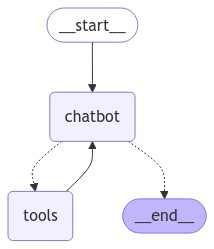

In [30]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
from langchain_core.messages import BaseMessage

# Start an infinite loop to continuously interact with the user
while True:
    # Prompt the user for input and capture their response
    user_input = input("User: ")

    # Check if the user wants to quit the interaction
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # Print a farewell message
        break  # Exit the loop, ending the program

    # Stream events from the graph using the user's input
    # The input is wrapped in a dictionary with "messages" key containing a list of tuples (message type, content)
    for event in graph.stream({"messages": [("user", user_input)]}):

        # Iterate over the values produced by each event in the stream
        for value in event.values():

            # Check if the last message in the list is an instance of BaseMessage
            if isinstance(value["messages"][-1], BaseMessage):

                # Print the content of the Assistant's response
                print("Assistant:", value["messages"][-1].content)

User: what is the current temparature of Bengaluru?
Assistant: 
Assistant: [{"url": "https://www.timeanddate.com/weather/india/bangalore/hourly", "content": "Weather Today Weather Hourly 14 Day Forecast Yesterday/Past Weather Climate (Averages) Currently: 73 \u00b0F. Fog. (Weather station: Bangalore / Hindustan, India). See more current weather."}, {"url": "https://www.timeanddate.com/weather/india/bangalore", "content": "Weather in Bengaluru, Karnataka, India. Time/General; Weather . Weather Today/Tomorrow ; Hour-by-Hour Forecast ; 14 Day Forecast ; Yesterday/Past Weather; Climate (Averages) ... Bangalore / Hindustan: Current Time: Nov 10, 2024 at 3:46:40 pm: Latest Report: Nov 10, 2024 at 3:00 pm: Visibility: 5 mi: Pressure: 29.95 \"Hg (27.12 \"Hg at 876m altitude)"}]
Assistant: The current temperature in Bengaluru is 73°F with fog.
User: q
Goodbye!
